# NX-421 Mini Project — Group P, Variant 1 (PCA) with Preprocessing

## Pipeline
1. **Project setup & inputs**
2. **Structural preprocessing (T1)**: skull-strip (mask-based), tissue segmentation, normalization
3. **Functional preprocessing (T2)**: data visualisation, checking for problematic volumes, masking, variance normalisation, motion correction, coregistration, spatial smoothing
4. **Design matrix (concatenated)**
5. **First-level GLM**
6. **Example contrast**
6. **PCA**


## Set-Up

### 1a. Import Libraries

In [14]:
%gui wx
import sys
import os

notebook_dir = os.path.abspath("")
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)
sys.path.append('.')
from utils import loadFSL, FSLeyesServer, mkdir_no_exist, interactive_MCQ

os.environ["DIPY_HOME"] = "/home/pvanden/Desktop/MyFiles/NSSP_Project1_TeamP"

import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()
loadFSL()

import fsl.wrappers
from fsl.wrappers import fslmaths

import mne_nirs
import nilearn
from nilearn.datasets import fetch_development_fmri

import mne
import mne_nirs
import dipy
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects
import xml.etree.ElementTree as ET
import os.path as op
import nibabel as nib
import glob

!pip install antspyx
import ants

import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report

import requests
import urllib.request
from tqdm import tqdm

from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt

import glob
import pandas as pd
import numpy as np
import json
import subprocess

import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning

### 1b. Import data

In [2]:
pwd

'/neurodesktop-storage'

In [2]:
bids_root = "fMRI_Data" 
print(os.path.exists(bids_root))
#derivatives = op.join(os.path.abspath(""),bids_root, "derivatives/preprocessed_data/subject101410") 
#mkdir_no_exist(derivatives)
LR_Motor = bids_root + '/tfMRI_MOTOR_LR.nii' 
RL_Motor = bids_root + '/tfMRI_MOTOR_RL.nii' 
print_dir_tree(bids_root, max_depth=5) 

True
|fMRI_Data/
|--- tfMRI_MOTOR_LR.nii
|--- tfMRI_MOTOR_RL.nii
|--- .ipynb_checkpoints/


In [3]:
#Start FSLeyes
fsleyesDisplay = FSLeyesServer()
fsleyesDisplay.show()

11:59:32: Debug: Adding duplicate image handler for 'Windows bitmap file'
11:59:32: Debug: Adding duplicate animation handler for '1' type
11:59:32: Debug: Adding duplicate animation handler for '2' type
11:59:32: Debug: Adding duplicate image handler for 'Windows bitmap file'
11:59:32: Debug: Adding duplicate animation handler for '1' type
11:59:32: Debug: Adding duplicate animation handler for '2' type

(ipykernel_launcher.py:19922): Gtk-CRITICAL **: 11:59:32.545: gtk_window_resize: assertion 'height > 0' failed


### 2. Structural Preprocessing 

### 2a. Skull stripping

In [ ]:
# Display Strcutural Image
fsleyesDisplay.load('T1w.nii.gz')

In [ ]:
def skull_strip_single_t1(t1_path, robust=False):
    """
    Skull-strip a single T1w image using FSL BET.
    Saves *_brain.nii.gz and *_mask.nii.gz next to the input file.
    """
    t1_dir = os.path.dirname(t1_path)
    t1_base = os.path.splitext(os.path.splitext(os.path.basename(t1_path))[0])[0]  # removes .nii.gz
    output_path = os.path.join(t1_dir, t1_base + "_brain")

    cmd = f"bet {t1_path} {output_path} -m {'-R' if robust else ''}"
    print(f"Running: {cmd}")
    os.system(cmd)
    print("Skull stripping complete!")

# Call it on your file
skull_strip_single_t1('T1w.nii.gz')

In [ ]:
# Display
fsleyesDisplay.load('T1w_brain.nii.gz')
fsleyesDisplay.load('T1w_brain_mask.nii.gz')

In [ ]:
def apply_python_mask_approach(img_path, mask_path, masked_img_path):
    """
    Parameters
    ----------
    img_path: str
        Path to the image on which we would like to apply the mask (in your case, the T1 with the skull still on). Should be a .nii.gz file
    mask_path: str
        Path to the mask you would like to apply to your image. Should be a .nii.gz file, containing only binary values (0 or 1)
    masked_img_path: str
        Path to which the resulting image will be saved.
    """
    import nibabel as nib

    # Load both the T1 and the mask from disk
    img = nib.load(img_path)
    mask = nib.load(mask_path)
    
    # Load the data from both above images as numpy arrays
    img_data = img.get_fdata()
    mask_data = mask.get_fdata()

    # Create an empty image and select all which falls in the mask
    # In all positions within the mask, get the image content
    saved_img_data = np.zeros(img_data.shape)
    saved_img_data[mask_data > 0] = img_data[mask_data > 0]

    # Save the image to disk, by creating a new Nifti image and then writing it out
    img_out = nib.Nifti1Image(saved_img_data,img.affine, img.header)
    nib.save(img_out, masked_img_path)

def apply_fsl_math_approach(img_path, mask_path, masked_img_path):
    os.system('fslmaths {} -mas {} {}'.format(img_path, mask_path, masked_img_path))

In [ ]:
data_dir = os.getcwd()  # Change paths for your own data if needed!

# Input and output paths
anatomical_path = os.path.join(data_dir, 'T1w.nii.gz')                  # Original brain (with skull)
betted_brain_path = os.path.join(data_dir, 'T1w_brain.nii.gz')          # Skull-stripped brain
resulting_mask_path = os.path.join(data_dir, 'T1w_brain_mask.nii.gz')   # Brain mask

########################
# Apply the FSL math approach
########################
apply_fsl_math_approach(anatomical_path, resulting_mask_path, betted_brain_path)

In [ ]:
# Display
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(betted_brain_path)

### 2b. Tissue Segmentataion

In [ ]:
import os, glob
from fsl.wrappers import fast


# Change the paths if needed!
data_dir = os.getcwd()  
anatomical_path = os.path.join(data_dir, 'T1w.nii.gz')           # Original brain
bet_path = os.path.join(data_dir, 'T1w_brain.nii.gz')            # Skull-stripped brain (output of BET)
segmentation_path = os.path.join(data_dir, 'T1w_fast')           # Output prefix for segmentation results

# Clean up old FAST results
for f in glob.glob(os.path.join(data_dir, '*fast*')):
    os.remove(f)

# Run FAST segmentation on skull-stripped brain
fast_target = bet_path  # BET result is recommended for segmentation
fast(imgs=[fast_target], out=segmentation_path, n_classes=3)

print("FAST segmentation complete!")

In [ ]:
# Display
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(bet_path)  # base brain

# Load the three partial volume estimate maps (gray matter, white matter, CSF)
fsleyesDisplay.load(glob.glob(os.path.join(data_dir, '*pve_0*'))[0])  # CSF
fsleyesDisplay.load(glob.glob(os.path.join(data_dir, '*pve_1*'))[0])  # Gray Matter
fsleyesDisplay.load(glob.glob(os.path.join(data_dir, '*pve_2*'))[0])  # White Matter

# Assign colors for clarity
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[1]).cmap = 'Red'    # CSF
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[2]).cmap = 'Green'  # GM
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[3]).cmap = 'Blue'   # WM

### 3. Functional Preprocessing 

### 3a. Visualising Data

In [4]:
import nibabel as nib
import numpy as np

def load_img_data(path):
    img = nib.load(path)
    data = img.get_fdata(dtype=np.float32)  
    return img, data

def brain_mask_from_nonzero(data, threshold=1e-6):
    """
    Creates brain mask for voxels with mean absolute intensity > threshold.
    This excludes background zeros but keeps all real voxels.
    """
    mean_signal = np.mean(np.abs(data), axis=3)
    mask = mean_signal > threshold
    return mask

def global_variance_over_mask(data, mask):
    """Compute global variance across all brain voxels and timepoints."""
    brain_ts = data[mask]  
    return np.var(brain_ts)

# File paths
run1 = LR_Motor
run2 = RL_Motor

# Load both runs
img1, d1 = load_img_data(run1)
img2, d2 = load_img_data(run2)

print(img1.shape)
print(img2.shape)

(91, 109, 91, 284)
(91, 109, 91, 284)


Text(0, 0.5, 'Mean voxel intensity')

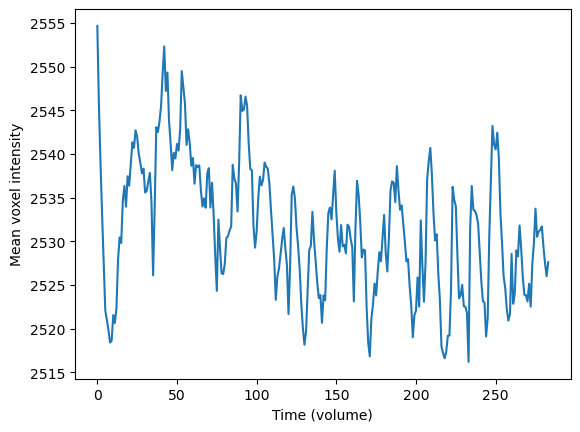

In [6]:
import matplotlib.pyplot as plt
import nibabel as nib

plt.plot(nib.load(LR_Motor).get_fdata().mean(axis=(0,1,2)))
plt.xlabel('Time (volume)')
plt.ylabel('Mean voxel intensity')

No volumes to remove based on voxel intensity.

### 3b. Create mask, rescale for variance = 1 and visualise

In [5]:
# Threshold to remove background noise
mask1 = brain_mask_from_nonzero(d1, threshold=1e-6)
mask2 = brain_mask_from_nonzero(d2, threshold=1e-6)

# Compute global variance for each run
var1 = global_variance_over_mask(d1, mask1)
var2 = global_variance_over_mask(d2, mask2)

# ---- Rescale so variance = 1 ----
d1_scaled = d1 / np.sqrt(var1)
d2_scaled = d2 / np.sqrt(var2)

print(global_variance_over_mask(d1_scaled, mask1))
print(global_variance_over_mask(d2_scaled, mask2))

# Save processed data and masks
nib.save(nib.Nifti1Image(d1_scaled, img1.affine, img1.header.copy()), 'd1_scaled.nii.gz')
nib.save(nib.Nifti1Image(d2_scaled, img2.affine, img2.header.copy()), 'd2_scaled.nii.gz')
nib.save(nib.Nifti1Image(mask1.astype(int), img1.affine, img1.header.copy()), 'mask1.nii.gz')
nib.save(nib.Nifti1Image(mask2.astype(int), img2.affine, img2.header.copy()), 'mask2.nii.gz')

# Launch FSLeyes with the saved files
subprocess.Popen(['fsleyes', 'd1_scaled.nii.gz', 'mask1.nii.gz', 'd2_scaled.nii.gz', 'mask2.nii.gz'])

0.99999756
1.0000005


### 3c. Concatenate runs

In [6]:
# Concatenate along time (4th dimension) 
concat = np.concatenate((d1_scaled, d2_scaled), axis=3)
print(concat.shape)

(91, 109, 91, 568)


In [7]:
# Save output 
save_path = "/home/jovyan/Data/group_project"
out_path = save_path +"/fMRI_motor_concat_var1.nii.gz"
mkdir_no_exist(save_path)

out_img = nib.Nifti1Image(concat, img1.affine, img1.header)
nib.save(out_img, out_path)

print(f"Saved concatenated, variance-normalized fMRI:\n{out_path}")

Saved concatenated, variance-normalized fMRI:
/home/jovyan/Data/group_project/fMRI_motor_concat_var1.nii.gz


In [8]:
fsleyesDisplay = FSLeyesServer() 
fsleyesDisplay.show() 
fsleyesDisplay.resetOverlays() 
fsleyesDisplay.load(out_path)


(ipykernel_launcher.py:16504): Gdk-WARNING **: 11:30:30.061: gdkdrawable-x11.c:952 drawable is not a pixmap or window


### 3d. Motion Correction

In [8]:
from fsl.wrappers import mcflirt 
save_path = "/home/jovyan/Data/group_project"
out_path = save_path+"/fMRI_motor_concat_var1.nii.gz" 
moco_path = save_path+"/moco_mot_corr"
mkdir_no_exist(moco_path)
mcflirt(infile=out_path,o=moco_path+'/moco', plots=True, report=True, dof=6, mats=True)

Processed data will be saved as /home/jovyan/Data/group_project/moco_mot_corr/moco

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [284] to 8 mm pixels
Registering volumes ... [285][286][287][288][289][290][291][292][293][294][295][296][297][298][299][300][301][302][303][304][305][306][307][308][309][310][311][312][313][314][315][316][317][318][319][320][321][322][323][324][325][326][327][328][329][330][331][332][333][334][335][336][337][338][339][340][341][342][343][344][345][346][347][348][349][350][351][352][353][354][355][356][357][358][359][360][361][362][363][364][365][366][367][368][369][370][371][372][373][374][375][376][377][378][379][380][381][382][383][384][385][386][387][388][389][390][391][392][393][394][395][396][397][398][399][400][401][402][403][404][405][406][407][408][409][410][411][412][413][414][415][416][417][418][419][420][421][422][423][424][425][426][427][428][429][430][431]

refnum = 284
Original_refvol = -1


Registering volumes ... [285][286][287][288][289][290][291][292][293][294][295][296][297][298][299][300][301][302][303][304][305][306][307][308][309][310][311][312][313][314][315][316][317][318][319][320][321][322][323][324][325][326][327][328][329][330][331][332][333][334][335][336][337][338][339][340][341][342][343][344][345][346][347][348][349][350][351][352][353][354][355][356][357][358][359][360][361][362][363][364][365][366][367][368][369][370][371][372][373][374][375][376][377][378][379][380][381][382][383][384][385][386][387][388][389][390][391][392][393][394][395][396][397][398][399][400][401][402][403][404][405][406][407][408][409][410][411][412][413][414][415][416][417][418][419][420][421][422][423][424][425][426][427][428][429][430][431][432][433][434][435][436][437][438][439][440][441][442][443][444][445][446][447][448][449][450][451][452][453][454][455][456][457][458][459][460][461][462][463][464][465][466][467][468][469][470][471][472][473][474][475][476][477][478][479][

{}

In [ ]:
fsleyesDisplay = FSLeyesServer() 
fsleyesDisplay.show() 
fsleyesDisplay.resetOverlays() 
fsleyesDisplay.load(moco_path+"/moco.nii.gz")

### 3e. Coregistration

In [ ]:
epi_source = moco_path + "/moco.nii.gz"
coreg_path = 'home/joyvan/Data/group_project/coreg'
mkdir_no_exist(coreg_path)

ref_vol_name = moco_path + '/moco_vol_middle'
mid_vol_index = 568 // 2 #length of sequence = 568
fslroi(epi_source, ref_vol_name, str(mid_vol_index), str(1))

# T1 and preprocessed-T1 locations
whole_t1 = bids_root + '/subject101410/T1w/T1w.nii.gz'
skull_stripped_t1 = bids_root + '/subject101410/T1w/T1w_brain.nii.gz'
white_matter_segmentation = bids_root + '/subject101410/T1w/T1w_fast_pve_2.nii.gz' # We provide the white matter segmentation

# coregistration on middle volume
output_path = coreg_path + '/moco_vol_bbr'
subprocess.run(['epi_reg','--epi={}'.format(ref_vol_name), '--t1={}'.format(whole_t1), '--t1brain={}'.format(skull_stripped_t1), 
                '--out={}'.format(output_path),
               '--wmseg={}'.format(white_matter_segmentation)])

In [ ]:
# Visualise overlay in FSLeyes
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(skull_stripped_t1) #source
fsleyesDisplay.load(output_path) #target

The orientation of the EPI and T1 volume are similar about the centre as seen on the overlay, indicating a good alignment overall. However, there are slight 
mismatches at the outer edges, likely due to the small differences in the original T1 and brain-mask used to extract skull-stripped volume.
We have used white matter masks generated by our segmentation process, so any pre-existing noise in the segmentation mask would have been carried over.

### 3f. Gaussian Smoothing

In [12]:
img = nib.load(moco_path+ "/moco.nii.gz")
voxel_sizes = img.header.get_zooms()
print("Voxel sizes (mm):", voxel_sizes[:3]) 

Voxel sizes (mm): (2.0, 2.0, 2.0)


In [10]:
sigma = 4 / 2.3548 #FWHM = 4mm = 2*2mm
img_path = moco_path+ "/moco.nii.gz"
smoothed_path = img_path.replace('.nii', '_smoothed-4mm.nii')
subprocess.run(['fslmaths', img_path, '-s', str(sigma), smoothed_path])
#subprocess.Popen(['fsleyes', smoothed_path])

CompletedProcess(args=['fslmaths', '/home/jovyan/Data/group_project/moco_mot_corr/moco.nii.gz', '-s', '1.6986580601324954', '/home/jovyan/Data/group_project/moco_mot_corr/moco_smoothed-4mm.nii.gz'], returncode=0)

In [11]:
fsleyesDisplay = FSLeyesServer() 
fsleyesDisplay.show() 
fsleyesDisplay.resetOverlays() 
fsleyesDisplay.load(smoothed_path)


(ipykernel_launcher.py:19922): Gdk-WARNING **: 12:17:09.683: gdkdrawable-x11.c:952 drawable is not a pixmap or window


### 4. GLM

In [18]:
events_LR = pd.read_csv('events_LR.csv')
events_RL = pd.read_csv('events_RL.csv')
events = pd.concat([events_LR, events_RL], ignore_index=True)
events

,onset,duration,condition
0,0.0,8.0,NaN
1,8.0,3.0,cue
2,11.0,12.0,rh
3,23.0,3.0,cue
4,26.0,12.0,lf
5,38.0,3.0,cue
6,41.0,12.0,t
7,53.0,3.0,cue
8,56.0,12.0,rf
9,68.0,3.0,cue


In [19]:
events['condition'] = events['condition'].fillna('start')

In [ ]:
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel

fmri_glm = FirstLevelModel(t_r=0.72,
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           drift_model=None,
                           high_pass=.01)

fmri_glm = fmri_glm.fit(smoothed_path, events)

In [ ]:
smoothed_path

In [ ]:
from nilearn.plotting import plot_design_matrix
plot_design_matrix(fmri_glm.design_matrices_[0])
plt.show()